In [1]:
#!/bin/python3
import ctypes
from ctypes import *
import numpy as np
from matplotlib import pyplot as plt
import SocketTransfer
from pyqhyccd import *
qhyccd = CDLL('/usr/local/lib/libqhyccd.so')
qhyccd.GetQHYCCDParam.restype=c_double
qhyccd.OpenQHYCCD.restype=ctypes.POINTER(c_uint32)
# ref: https://www.qhyccd.com/bbs/index.php?topic=6356.0
# H.F. @20191115

Python Knowledge
+ https://docs.python.org/3/library/ctypes.html

QHY POST
+ https://www.qhyccd.com/bbs/index.php?topic=6316.0
+ https://www.qhyccd.com/bbs/index.php?topic=6356.0
+ https://www.qhyccd.com/bbs/index.php?topic=6663.0
+ https://github.com/EastEriq/QHYccd-matlab

In [3]:
# Create server object
server = SocketTransfer.socket_server()

In [4]:
server.connect()

Client ('10.20.35.182', 48208) connected


In [1009]:
ret = -1
qhyccd.InitQHYCCDResource()
qhyccd.ScanQHYCCD()
type_char_array_32 = c_char*32
id=type_char_array_32()
qhyccd.GetQHYCCDId(c_int(0), id)    # open the first camera
print(id.value)
cam = qhyccd.OpenQHYCCD(id)
qhyccd.SetQHYCCDStreamMode(cam, 0)  # 0 for single frame
qhyccd.InitQHYCCD(cam)

b'QHY163M-8cf4dc43a8fe4f8f'


0

In [1010]:
qhyccd.SetQHYCCDParam(cam, CONTROL_ID.CONTROL_USBTRAFFIC, c_double(50)) 

0

In [1028]:
qhyccd.GetQHYCCDParam(cam, CONTROL_ID.CONTROL_CURTEMP)

-4.5

In [1017]:
qhyccd.SetQHYCCDParam(cam, CONTROL_ID.CONTROL_MANULPWM, c_double(100))

0

In [1018]:
qhyccd.GetQHYCCDParam(cam, CONTROL_ID.CONTROL_CURPWM)

100.0

In [1029]:
qhyccd.SetQHYCCDResolution(cam, 0, 0, 1024, 1024)

0

In [5]:
# Get Camera Parameters
chipw = c_double()
chiph = c_double()
w = c_uint()
h = c_uint()
pixelw = c_double()
pixelh = c_double() 
bpp = c_uint()
channels = c_uint32(1)
qhyccd.GetQHYCCDChipInfo(cam, byref(chipw), byref(chiph), byref(w), byref(h),
                         byref(pixelw), byref(pixelh), byref(bpp)); 

## Capture single frame

In [1032]:
imgdata = (ctypes.c_uint16 * h.value*w.value)()
qhyccd.SetQHYCCDParam(cam, CONTROL_ID.CONTROL_EXPOSURE, c_double(400000)) # unit: us
for i in range(10):
    ret = qhyccd.ExpQHYCCDSingleFrame(cam)
    print("exp", ret, end=' ')
    ret = qhyccd.GetQHYCCDSingleFrame(
        cam, byref(w), byref(h), byref(bpp), byref(channels), imgdata)
    print("get", ret)
    x = np.asarray(imgdata)
    server.send_img(x.reshape([h.value, w.value]))

exp 8193 get 0
exp 8193 get 0
exp 8193 get 0
exp 8193 get 0
exp 8193 get 0
exp 8193 get 0
exp 8193 get 0
exp 8193 get 0
exp 8193 get 0
exp 8193 get 0


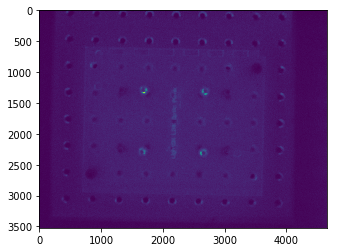

In [67]:
plt.imshow(x.reshape([h.value, w.value]))
server.send_img(x.reshape([h.value, w.value]))

In [1008]:
qhyccd.CloseQHYCCD(cam)
qhyccd.ReleaseQHYCCDResource()

0